In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/libraries.py /content
import libraries


In [ ]:

DATA_PATH = '/content/drive/MyDrive/sipakmed/sipakmed/'

Mounted at /content/drive


In [ ]:
!pip install torchviz
!pip install torchsummary
!apt-get install graphviz -y
!pip install graphviz
!pip install Pillow
from torchviz import make_dot


In [ ]:
# Import the module
!cp /content/drive/MyDrive/sipakmed/modular/dataset_management.py /content

import dataset_management


i used this to make sure there isn't duplicated data and data for training was succesful

i used this to check now how many files i have knowing that my data for sipakmed originally were 4049 bmb files

In [ ]:
# Get a list of all image file paths
file_paths = []
categories = []

for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith('.bmp'):
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
            if 'normal' in file_path:
                categories.append(0)
            else:
                categories.append(1)

In [ ]:
import libraries
df = libraries.pd.DataFrame({'filename (X)': file_paths, 'category (Y)': categories})
df

In [ ]:
import os
import shutil
import random
# Specify the path to your dataset on Google Drive
drive_path = '/content/drive/MyDrive/sipakmed/sipakmed/'

# Define the output directory for your divided dataset on Google Drive
output_dir = '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training'


to check if my data are balanced regarding the training ones or not

Directory: /content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/, BMP File Count: 5886
Directory: /content/drive/MyDrive/sipakmed/sipakmed/, BMP File Count: 11772
Total BMP File Count in '/content/drive/MyDrive/sipakmed/sipakmed/': 11772
Total BMP File Count in '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/': 5886


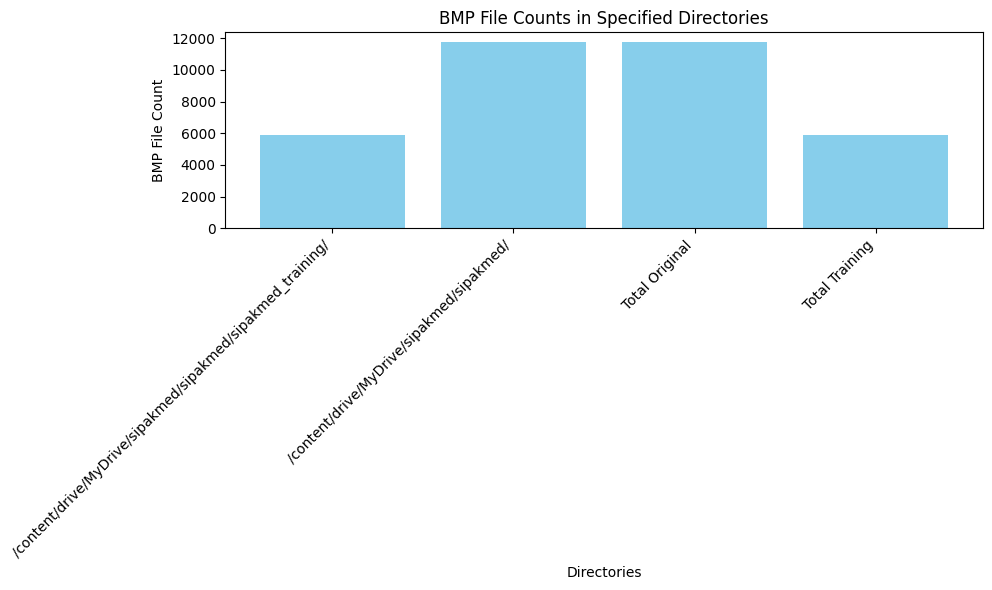

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/sipakmed/modular')

import check_balanced_data
check_balanced_data.check_balanced_data()


data balance in normal and atypical

In [ ]:
import random
import dataset_management

# Function to balance data by randomly undersampling the majority class
def balance_data(train_files):
    normal_files = [file for file in train_files if 'normal' in file]
    atypical_files = [file for file in train_files if 'atypical' in file]

    min_samples = min(len(normal_files), len(atypical_files))

    balanced_data = random.sample(normal_files, min_samples) + random.sample(atypical_files, min_samples)
    return balanced_data


In [ ]:
def check_balance(data):
    normal_count = sum(1 for file in data if 'normal' in file)
    atypical_count = sum(1 for file in data if 'atypical' in file)

    return normal_count, atypical_count

# Call the balance_data function to get the balanced dataset
balanced_train_data = balance_data(train_files)

# Check the balance
normal_count, atypical_count = check_balance(balanced_train_data)
print(f"Normal samples: {normal_count}, Atypical samples: {atypical_count}")

if normal_count == atypical_count:
    print("The data is balanced.")
else:
    print("The data is not balanced.")


Normal samples: 2179, Atypical samples: 2179
The data is balanced.


Data preprocessing and loading using torchvision


 load images and their labels from the balanced_dataset:

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score

# Define your parameters
IMAGE_HEIGHT = 125
IMAGE_WIDTH = 125
IMAGE_CHANNELS = 3
DATA_PATH = "/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training"
BATCH_SIZE = 16
EPOCHS = 50
PATIENCE = 13

# Define your data transformation without data augmentation
transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the path for train, val, and test
train_path = os.path.join(DATA_PATH, 'train')
val_path = os.path.join(DATA_PATH, 'val')
test_path = os.path.join(DATA_PATH, 'test')

# Load the dataset using ImageFolder
train_dataset = ImageFolder(root=train_path, transform=transform)
val_dataset = ImageFolder(root=val_path, transform=transform)
test_dataset = ImageFolder(root=test_path, transform=transform)

# Set up DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define your MobileNetV3 Small model
model = models.mobilenet_v3_small(pretrained=True)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(train_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Early stopping
best_val_loss = float('inf')
no_improvement_count = 0

# Training loop
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

# Train the model
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    train_preds = []
    train_labels = []

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_accuracy = accuracy_score(train_labels, train_preds)

    # Validate the model
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Append metrics for later plotting
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= PATIENCE:
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Evaluate on test set
model.eval()
test_loss = 0.0
test_preds = []
test_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = accuracy_score(test_labels, test_preds)

print(f"Final Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
torch.save(model.state_dict(), "mobilenetv30.0001_small.pth")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Training Loss: 0.33537637204041376, Training Accuracy: 0.8567467652495379, Validation Loss: 0.5021976764373323, Validation Accuracy: 0.7402422611036339
Epoch 2, Training Loss: 0.1638042211313458, Training Accuracy: 0.9413123844731978, Validation Loss: 0.37286801604514425, Validation Accuracy: 0.8398384925975774
Epoch 3, Training Loss: 0.13001477002056644, Training Accuracy: 0.9528650646950092, Validation Loss: 0.14454120607610713, Validation Accuracy: 0.9434724091520862
Epoch 4, Training Loss: 0.11036536050960422, Training Accuracy: 0.9634935304990758, Validation Loss: 0.08333633281290531, Validation Accuracy: 0.9757738896366084
Epoch 5, Training Loss: 0.07165057739920859, Training Accuracy: 0.9768946395563771, Validation Loss: 0.06394316926920549, Validation Accuracy: 0.9811574697173621
Epoch 6, Training Loss: 0.07235235604799956, Training Accuracy: 0.9787430683918669, Validation Loss: 0.06759620236574691, Validation Accuracy: 0.9784656796769852
Epoch 7, Training Loss: 0.0429

NameError: ignored

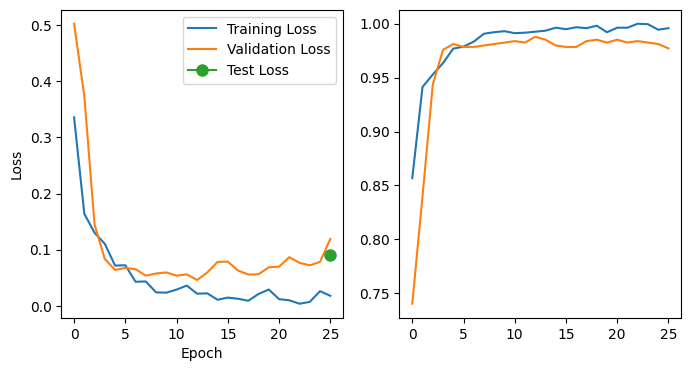

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/acc_loss_curves.py /content
import acc_loss_curves

In [ ]:
pip install seaborn matplotlib numpy scikit-learn


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Define a function to plot the confusion matrix heatmap
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    classes = unique_labels(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot the confusion matrix for the test set
plot_confusion_matrix(test_labels, test_preds, classes=train_dataset.classes, title='Confusion Matrix - Test Set')

plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(test_labels, test_preds)
pr_auc = auc(recall, precision)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC={0:0.2f}'.format(pr_auc))
plt.show()


In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/evaluation_metrics.py /content
import evaluation_metrics


F1 Score: 0.9851, Precision: 0.9851, Recall: 0.9851
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       490
           1       0.98      0.99      0.99       652

    accuracy                           0.99      1142
   macro avg       0.99      0.98      0.98      1142
weighted avg       0.99      0.99      0.99      1142



Overall, these metrics indicate that your model is performing very well on the test set, with high precision, recall, and F1 score.







In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Number of trainable parameters in the model: {num_params}")


Number of trainable parameters in the model: 1519906


In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/sample_input_time.py /content
import sample_input_time

Inference time for a sample input: 0.02448749542236328 seconds
